In [2]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from scipy.linalg import orthogonal_procrustes

import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed

from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed
from scipy.linalg import orthogonal_procrustes
from graspologic.plot import heatmap
from sklearn.manifold import Isomap
import piecewise_regression
from sklearn.linear_model import LinearRegression


from kneed import DataGenerator, KneeLocator


plt.ion()


def filter_matrix_TC(data, well):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well]['win_0']['adj_matrix_predicted']
    votes = data[well]['win_0']['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well]['win_0']['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix

import warnings

def find_optimal_neighbors(X):
    n_neighbors = 2
    while True:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                isomap = Isomap(n_neighbors=n_neighbors)
                isomap.fit(X)
                print(f"Successful with n_neighbors={n_neighbors}")
                return n_neighbors
        except Warning as w:
            print(f"Warning encountered with n_neighbors={n_neighbors}: {w}")
            n_neighbors += 1




from scipy.stats import norm

def get_elbows(dat, n=3, threshold=False, plot=True, main=""):
    """
    Given a decreasingly sorted vector, return the given number of elbows.

    Args:
        dat: an input vector (e.g. a vector of standard deviations) or an input feature matrix.
        n: the number of returned elbows.
        threshold: either False or a number. If threshold is a number, then all
                   the elements in dat that are not larger than the threshold will be ignored.
        plot: logical. When True, it depicts a scree plot with highlighted elbows.
        main: title for the plot.

    Returns:
        q: a list of length n containing the positions of the elbows.
    """
    
    if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
        d = np.sort(np.std(dat, axis=0))[::-1]
    else:
        d = np.sort(dat)[::-1]

    if threshold is not False:
        d = d[d > threshold]

    p = len(d)
    if p == 0:
        raise ValueError(f"d must have elements that are larger than the threshold {threshold}!")

    lq = np.zeros(p)  # log likelihood, function of q
    for q in range(p):
        mu1 = np.mean(d[:q+1])
        mu2 = np.mean(d[q+1:]) if q < p-1 else np.nan
        sigma2 = (np.sum((d[:q+1] - mu1)**2) + np.sum((d[q+1:] - mu2)**2)) / (p - 1 - (q < p-1))
        lq[q] = (np.sum(norm.logpdf(d[:q+1], mu1, np.sqrt(sigma2))) + 
                 np.sum(norm.logpdf(d[q+1:], mu2, np.sqrt(sigma2))))

    q = [np.argmax(lq)]
    if n > 1 and q[0] < (p - 1):
        q.extend([q[0] + 1 + el for el in get_elbows(d[q[0]+1:], n-1, plot=False)])

    if plot:
        if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
            sdv = d
            plt.plot(sdv, marker='o')
            plt.xlabel("dim")
            plt.ylabel("stdev")
            plt.title(main)
            plt.scatter(q, sdv[q], s=100, color='red')
        else:
            plt.plot(dat, marker='o')
            plt.title(main)
            plt.scatter(q, dat[q], s=100, color='red')
        plt.show()

    return q

# Example usage
# dat = np.random.rand(100, 10)  # Example data
# elbows = get_elbows(dat)
# print(elbows)




In [3]:
## data's path and name together
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/2024May28 No window data /OneDrive_1_6-17-2024/Run_8_TBS_Experiment_ecr_results/'

os.chdir(dr)

dr1=dr+'230601 RUN 8 Wells 1-3'
dr2=dr+'230602 RUN 8 Wells 4-6'

filenames=os.listdir(dr1)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))

sorted_filenames_updated1=['230601 RUN 8 Wells 1-3/'+filename + '/data.raw_20240521_16h16m.pkl' for filename in sorted_filenames]

filenames=os.listdir(dr2)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))
sorted_filenames_updated2=['230602 RUN 8 Wells 4-6/'+filename + '/data.raw_20240521_16h16m.pkl' for filename in sorted_filenames]
sorted_filenames_updated=sorted_filenames_updated1+sorted_filenames_updated2

print('number of files:',len(sorted_filenames_updated))

number of files: 36


In [45]:
well='well005'
well_number = int(well[4:])+1

In [46]:
## extract the correpsonding stimulate time for the chosen well
df = pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Time-file.csv')
df['time'] = pd.to_datetime(df['Unnamed: 1'].astype(str) + ' ' + df['Unnamed: 2'].astype(str), errors='coerce')

for i in df.loc[df['Unnamed: 2'].isnull(),'time'].index:
    df.loc[i,'time'] = df.loc[i-1,'time']+pd.Timedelta(10,'min')

stimulus_time=df[df[str(well_number)]==True]['time']
time=df[df['Unnamed: 2'].notna()]['time']
time_diff = [(t - time[0]).total_seconds() / 60 for t in time]
stimulus_time_diff = [(t - time[0]).total_seconds() / 60 for t in stimulus_time]


## read in all the time series of graphs
all_adj = []
num_vertices = []
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    adj = filter_matrix_TC(data, well)
    all_adj.append(adj)
    num_vertices.append(adj.shape[0])

total_edges = 0
total_matrices = len(all_adj)

for adj in all_adj:
    total_edges += adj.sum()

average_edges = total_edges / total_matrices
print("Average number of edges:", average_edges)

Average number of edges: 34451.75


In [47]:
## add zeros to the adj mat such that they have the same dims 
dim = max(num_vertices) # Max number of vertices to determine dimension
m=len(all_adj)
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size
for i in range(m):
    ma = all_adj[i]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 
    
graph_matching=True

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline
for i in range(1, m):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    ofv=res['fun']
    fun_I = np.trace(adj_aug[i].T  @ adj_gm[i-1] )
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    #print(f"Frob diff before GM: {before_norm}, After GM: {after_norm},OFV before GM: {fun_I}, After GM: {ofv}")

In [48]:
choosen_time_points=range(m)
tm=choosen_time_points

D=np.zeros([len(tm),len(tm)])

ASE embedding dim 1 458
ASE embedding dim 1 451
ASE embedding dim 1 427
ASE embedding dim 1 407
ASE embedding dim 1 407
ASE embedding dim 1 407
ASE embedding dim 1 408
ASE embedding dim 1 403
ASE embedding dim 1 397
ASE embedding dim 1 373
ASE embedding dim 1 395
ASE embedding dim 1 391
ASE embedding dim 1 390
ASE embedding dim 1 377
ASE embedding dim 1 366
ASE embedding dim 1 381
ASE embedding dim 1 373
ASE embedding dim 1 370
ASE embedding dim 1 351
ASE embedding dim 1 356
ASE embedding dim 1 359
ASE embedding dim 1 358
ASE embedding dim 1 330
ASE embedding dim 1 325
ASE embedding dim 1 340
ASE embedding dim 1 329
ASE embedding dim 1 334
ASE embedding dim 1 341
ASE embedding dim 1 322
ASE embedding dim 1 326
ASE embedding dim 1 330
ASE embedding dim 1 329
ASE embedding dim 1 317
ASE embedding dim 1 331
ASE embedding dim 1 337
ASE embedding dim 1 320
ASE embedding dim 1 520
ASE embedding dim 1 505
ASE embedding dim 1 459
ASE embedding dim 1 450
ASE embedding dim 1 441
ASE embedding di

<AxesSubplot:title={'center':'Distance matrix between time points'}>

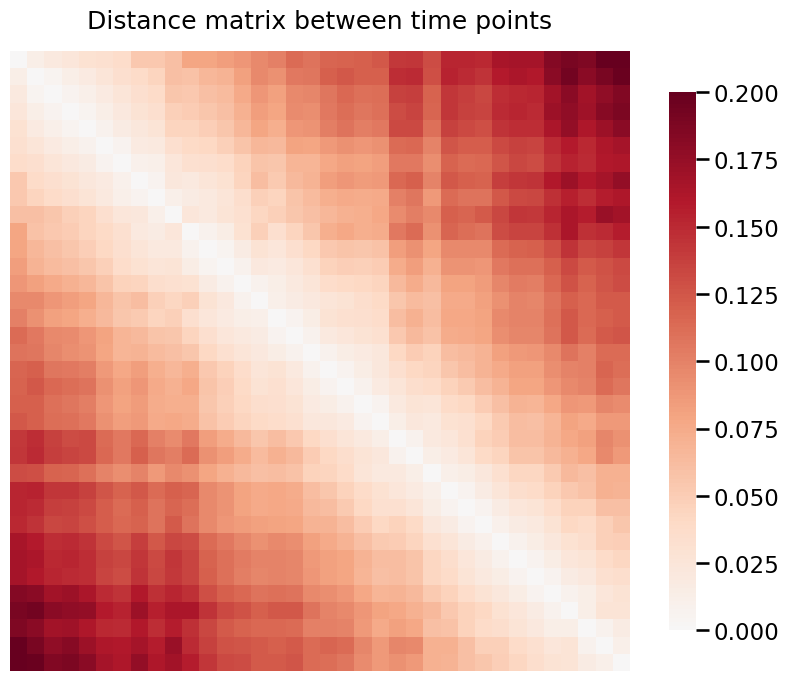

In [49]:
Pairwise_lccc=True
for i in range(len(tm)):
    for j in range(i,len(tm)):
        prod=adj_gm[choosen_time_points[i]] * adj_gm[choosen_time_points[j]]
        [a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
        n=len(ind)
        #print(i,j,n)
        glist=np.zeros([len(choosen_time_points),len(ind),len(ind)])
        glist[i]=adj_gm[choosen_time_points[i]][ind][:,ind]
        glist[j]=adj_gm[choosen_time_points[j]][ind][:,ind]
        #print(graspologic_utils.is_fully_connected(glist[i]))

        #if n<ed_old:
        #    ed=int(ed_old/3)
        #    print("ASE embedding dim",ed)
        

        s = np.linalg.svd(glist[i], compute_uv=False)
        #kneedle=KneeLocator(range(glist[i].shape[0]),s, curve="convex", direction="decreasing")
        #ed=kneedle.knee
        ed=get_elbows(s, n=1, plot=False)[0]+1
        print("ASE embedding dim",ed,n)

        Xhat_list=np.zeros([len(tm),n,2*ed])
        ase = AdjacencySpectralEmbed(n_components=ed)
        Xhat, Yhat = ase.fit_transform(glist[i])
        Xhat_list[i][:,list(np.arange(ed))]=Xhat
        Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

        Xhat, Yhat = ase.fit_transform(glist[j])
        Xhat_list[j][:,list(np.arange(ed))]=Xhat
        Xhat_list[j][:,list(np.arange(ed,2*ed))]=Yhat

        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  #Frobenius norm

D=D+D.T
heatmap(D, title="Distance matrix between time points")

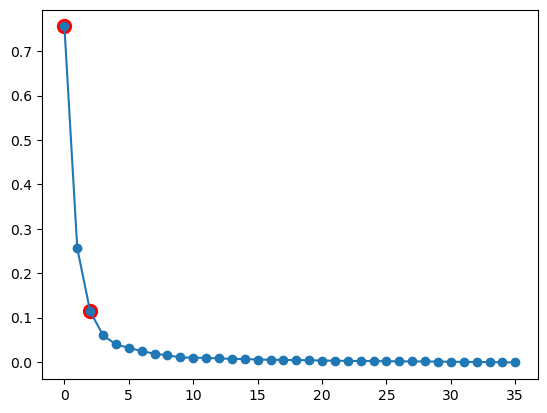

CMDS embedding dim: 3


In [50]:
## CMDS
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
#plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
#plt.xlabel('dimension',fontsize=15)
#plt.ylabel('eigen value',fontsize=15)
#kneedle=KneeLocator(range(len(tm)),w, curve="convex", direction="decreasing")
d=get_elbows(w, n=2, plot=True)[1]+1
print("CMDS embedding dim:", d)
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

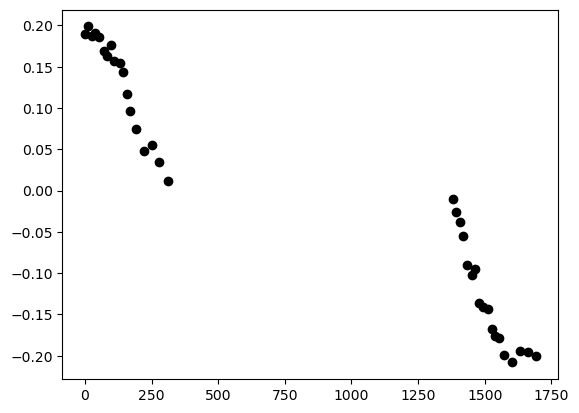

In [51]:
plt.scatter(time_diff,-MDS[:,0],color='black')

Text(0, 0.5, 'dim 2')

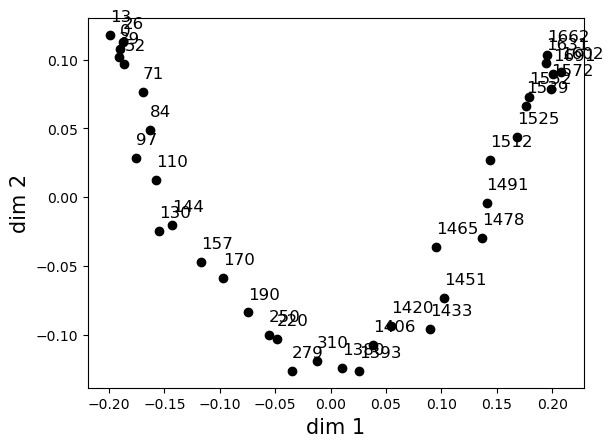

In [52]:
plt.scatter(MDS[:,0],-MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],-MDS[i,1]+0.01,int(time_diff[choosen_time_points[i]]), fontsize=12)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

Successful with n_neighbors=2


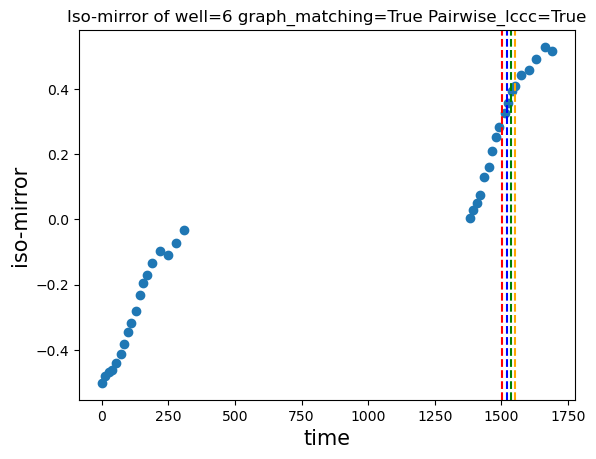

In [53]:
## ISOMAP fitting on CMDS result

optimal_n_neighbors = find_optimal_neighbors(MDS)
embedding = Isomap(n_neighbors=optimal_n_neighbors,n_components=1)
iso = embedding.fit_transform(MDS)
iso=iso[:,0]

if iso[0]>0:
    iso=-iso
else:
    iso=iso  

plt.scatter(time_diff,iso)
plt.xlabel("time",fontsize=15)
plt.ylabel("iso-mirror",fontsize=15)
plt.title("Iso-mirror of well=" + str(well_number)+' graph_matching='+str(graph_matching)+' Pairwise_lccc='+str(Pairwise_lccc))
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

In [54]:
pw_fit=piecewise_regression.ModelSelection(time_diff, iso, max_breakpoints=6)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 
Running fit with n_breakpoint = 6 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     -141.9         True      0.57287 
1                    -149.22         True      0.38307 
2                    -150.29         True       0.3047 
3                    -271.08         True    0.0087136 
4                                   False              
5                                   False              
6                                   False              

Min BIC (Bayesian Information Criterion) suggests best model


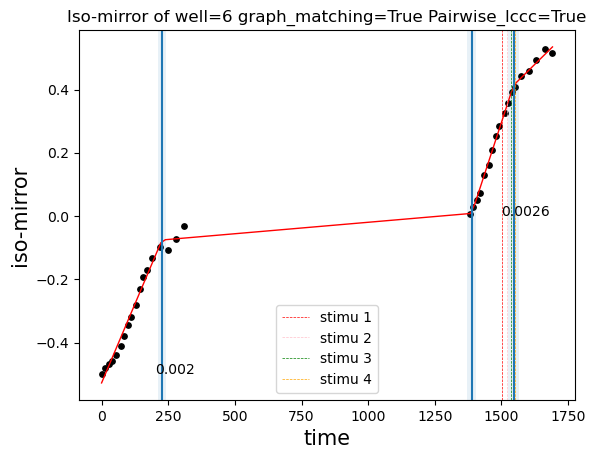

In [63]:
pw_fit = piecewise_regression.Fit(time_diff, iso, n_breakpoints=3)  ## choose the number of breakpoints based on result above 
pw_results = pw_fit.get_results()
pw_estimates = pw_results["estimates"]

### result for using iso-mirror
pw_fit.plot_data(color='black',s=15)
pw_fit.plot_fit(color="red", linewidth=1)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("time",fontsize=15)
plt.ylabel("iso-mirror",fontsize=15)
plt.title("Iso-mirror of well=" + str(well_number)+' graph_matching='+str(graph_matching)+' Pairwise_lccc='+str(Pairwise_lccc))
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1',lw=0.5)
plt.axvline(x=stimulus_time_diff[1], color='pink', linestyle='--', label='stimu 2',lw=0.5)
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3',lw=0.5)
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4',lw=0.5)
plt.legend()

plt.text(200, -0.5, str(round(pw_estimates['alpha1']['estimate'],4))  )

plt.text(1500, 0, str(round(pw_estimates['alpha3']['estimate'],4))  )


plt.show()
plt.close()



In [142]:
lr = LinearRegression()
lr.fit(np.array(time_diff[:18]).reshape(-1, 1), iso[:18,0])
beta = lr.coef_
beta

array([-0.00106514])

In [57]:
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                       36
No. Model Parameters                    8
Degrees of Freedom                     28
Res. Sum of Squares            0.00871364
Total Sum of Squares               3.8715
R Squared                        0.997749
Adjusted R Squared               0.997082
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const              -0.527815      0.00838      -63.018      1.02e-31     -0.54497     -0.51066
alpha1            0.00199498     6.99e-05       28.548      3.02e-22    0.0018518    0.0021381
beta1            -0.00192255     7.23e-05      -26.596             -   -0.0020706   -0.0017745
beta2              0.0025107     0.000115       21.766             -    0.0022744     0.002747
beta3            

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       36\nNo. Model Parameters                    8\nDegrees of Freedom                     28\nRes. Sum of Squares            0.00871364\nTotal Sum of Squares               3.8715\nR Squared                        0.997749\nAdjusted R Squared               0.997082\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst              -0.527815      0.00838      -63.018      1.02e-31     -0.54